<a href="https://colab.research.google.com/github/ChrisKantor/Deep-Learning/blob/main/Project%202/Deep_Learning_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Deep learning model that builds on the one made in HW3 for determining an infants pain level using vital signs
#This improved model uses LSTM to better understand the sequential readings



#Run these commands - NECCESARY to use the GPU
# export CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
# export LD_LIBRARY_PATH=${CUDNN_PATH}/lib

#To connect to local runtime: jupyter lab --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [1]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt
import PIL
from tensorflow import keras

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# dir = 'Deep Learning/Project 2/'
# data_dir = "data/"


## Mount Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 2/data/'


import os
print(os.getcwd())

Num GPUs Available:  0
Mounted at /content/drive
/content


# Data Preprocessing

In [ ]:
#NEEDS FURTHER CLARIFICATION:
#If a csv file sequence has an invalid row, do we just remove it or is the whole sequence invalid?
#Can we mix the csv sequences together to get a fixed length input sequence? or should each seperate csv file be treated as its own sequence?
#Are we predicting if the baby is in pain during the next timestep?



#lots to do here - roughly follow this tutorial for general RNN processing: https://www.tensorflow.org/text/tutorials/text_generation

#need sequences of data to use as input. Each csv file is 1 sequence, and each of them could potentially have missing/invalid data in them. 602 total csv files
#Each csv file has 30 entries, but due to missing/invalid data, our cleaned sequences could have any number of entries
#After cleaning the csv files, our dataset will be compromised of a bunch of variable length sequences
#we will split our dataset up into training/validation sets on a sequence level

#the inputs at a specific timestep will be the 3 labels in the csv files (Heart Rate, Respiratory Rate, O2 level) and the output will be (either if the baby is in pain OR if the baby is in pain during the NEXT step)? -Need clarification here

In [6]:
#store a list of dataframes representing the data from the csv files we read in
#after reading in all of the csv files as dataframes, iterate through them, cleaning up the data and normalizing the inputs


#Should we normalize on a dataframe level or a dataset level?


data = []


#use the os library to iterate through all files in the current path
for (root,dirs,files) in os.walk(data_dir, topdown=True):
  #open each CSV file, we don't want to open any other type of file
  for f in files:
    if f.endswith(".csv"):
      with open(os.path.join(root, f), mode ='r') as csvFile:

        #read in the csv file
        csvData = csv.reader(csvFile)

        #store the data temporarily before we turn it into a pandas dataframe
        temp = []


        #check if each row is valid
        #one way to tell if the data is invalid is if the label is NOT [0, 1, 2]. This means there was something wrong with one of the sensors at the time of capture
        #another way is to check if the heart rate, respiratory rate, or o2 level is too low or too high
        #for heart Rate, we want a range of 40 - 200
        #for Respiratory Rate, we want a range of 15 - 90
        #for o2 level, we want a rate of 80 - 100

        for row in csvData:
          try:
            if row[4] in "012" and (int(row[1]) >= 40 and int(row[1]) <= 200) and (int(row[2]) >= 15 and int(row[2]) <= 90) and (int(row[3]) >= 80 and int(row[3]) <= 100):   #data is valid, so add it to the main csv
              #row[0] just stores the row # in the csv file, so it is not needed in the training dataset
              temp.append([int(row[1]), int(row[2]), int(row[3]), int(row[4])])

          #Catches errors that occur when an element cannot be parsed into an integer. In this case the row is invalid so we can skip it
          except ValueError:
            continue

        #if this valid and cleaned sequence is NOT empty, add it to our dataset
        if len(temp) > 0:
          df = pd.DataFrame(temp, columns = ['Heart Rate', 'Respiratory Rate', 'O2 Level', 'Label'])
          data.append(df)

print(len(data))

487


In [7]:
#count sequence lengths and how often they appear
freqMap = {}
for d in data:
  if d.shape not in freqMap.keys():
    freqMap[d.shape] = 1

  else:
    freqMap[d.shape] += 1

for key, value in freqMap.items():
    print(f'{key} -> {value}')


#split data into training/validation sets using an 90/10 split
data = np.asarray(data, dtype="object")
np.random.shuffle(data)

trainData, valData = np.split(data, [int(0.90*len(data))])

print(len(trainData), len(valData))

#remove the labels from the trainingData and validation data, also storing them as a list
#we don't need the entire column of labels, just the first rows label
trainLabels = []
valLabels = []

for df in trainData:
  label = df['Label'].iloc[0]    #get the first rows label, and use it for this whole sequence
  df.drop('Label', axis=1, inplace=True)
  trainLabels.append(label)

for df in valData:
  label = df['Label'].iloc[0]    #get the first rows label, and use it for this whole sequence
  df.drop('Label', axis=1, inplace=True)
  valLabels.append(label)

trainLabels = np.asarray(trainLabels).astype('int32')
valLabels = np.asarray(valLabels).astype('int32')
print(trainData.shape, len(trainLabels))
print(valData.shape, len(valLabels))

trainLabelMap = {}
for label in trainLabels:
  if label not in trainLabelMap.keys():
    trainLabelMap[label] = 1
  else:
    trainLabelMap[label] += 1


valLabelMap = {}
for label in valLabels:
  if label not in valLabelMap.keys():
    valLabelMap[label] = 1
  else:
    valLabelMap[label] += 1

print(trainLabelMap)
print(valLabelMap)

(31, 4) -> 381
(30, 4) -> 31
(14, 4) -> 2
(29, 4) -> 21
(5, 4) -> 1
(11, 4) -> 1
(21, 4) -> 4
(4, 4) -> 1
(7, 4) -> 1
(27, 4) -> 10
(28, 4) -> 15
(25, 4) -> 4
(26, 4) -> 6
(17, 4) -> 2
(22, 4) -> 2
(24, 4) -> 2
(23, 4) -> 2
(15, 4) -> 1
438 49
(438,) 438
(49,) 49
{1: 160, 0: 252, 2: 26}
{0: 26, 1: 19, 2: 4}


In [8]:
#normalize data using only the training set
#find the min/max of each column throughout all of the dataframes in the training dataset
#save the values, then iterate through the training and validation dataset and use min-max normalization
#df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

#norm values stores the min/max of each column, initialized to min = float('inf'), max = float('-inf')
#[[Heart Rate Min, Heart Rate Max], [Respiratory Rate Min, Respiratory Rate Max], [O2 Level Min, O2 Level Max]]
normValues = [[float('inf'), float('-inf')], [float('inf'), float('-inf')], [float('inf'), float('-inf')]]

for df in trainData:
  normValues[0][0] = min(normValues[0][0], df['Heart Rate'].min())
  normValues[0][1] = max(normValues[0][1], df['Heart Rate'].max())

  normValues[1][0] = min(normValues[1][0], df['Respiratory Rate'].min())
  normValues[1][1] = max(normValues[1][1], df['Respiratory Rate'].max())

  normValues[2][0] = min(normValues[2][0], df['O2 Level'].min())
  normValues[2][1] = max(normValues[2][1], df['O2 Level'].max())

#now we have the min/max for each column across our whole dataset from our training data, so we can save this normalization, and apply it to the validation set
print(normValues)



#normalizing the data:
for df in trainData:
  df['Heart Rate'] = (df['Heart Rate'] - normValues[0][0]) / (normValues[0][1] - normValues[0][0])
  df['Respiratory Rate'] = (df['Respiratory Rate'] - normValues[1][0]) / (normValues[1][1] - normValues[1][0])
  df['O2 Level'] = (df['O2 Level'] - normValues[2][0]) / (normValues[2][1] - normValues[2][0])

for df in valData:
  df['Heart Rate'] = (df['Heart Rate'] - normValues[0][0]) / (normValues[0][1] - normValues[0][0])
  df['Respiratory Rate'] = (df['Respiratory Rate'] - normValues[1][0]) / (normValues[1][1] - normValues[1][0])
  df['O2 Level'] = (df['O2 Level'] - normValues[2][0]) / (normValues[2][1] - normValues[2][0])

[[44, 199], [15, 90], [80, 100]]


In [9]:
#Data padding
#inputs to GRU cells are in the form of [batch, timesteps, feature]
#our sequences have multiple lengths, so we need to pad this data to get all of the sequences to have a length of 31 (indices 0-30)
#we can pad the data by adding rows of 0's, and use a masking layer to ignore them when training the model

for i in range(len(trainData)):
  if trainData[i].shape[0] < 31:
    padding = pd.DataFrame(0, index=np.arange(trainData[i].shape[0], 31), columns=trainData[i].columns)
    trainData[i] = pd.concat([trainData[i], padding])

for i in range(len(valData)):
  if valData[i].shape[0] < 31:
    padding = pd.DataFrame(0, index=np.arange(valData[i].shape[0], 31), columns=valData[i].columns)
    valData[i] = pd.concat([valData[i], padding])

In [10]:
#convert dataframes into np arrays and make the whole dataset multidimensional instead of an array of dataframes for tensorflow to properly use
trainData = np.array([np.array(val) for val in trainData])
valData = np.array([np.array(val) for val in valData])

# Model Setup

In [17]:
#first model uses 4 GRU layers with 16 unit each
#input is taken in the form of: [batch, timesteps, feature]
#Since our sequences have different lengths, we need to pad them
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Masking(mask_value=0., input_shape=(31, 3)),
#     tf.keras.layers.GRU(16, return_sequences=True, return_state=True),
#     tf.keras.layers.GRU(16, return_sequences=True, return_state=True),
#     tf.keras.layers.GRU(16, return_sequences=True, return_state=True),
#     tf.keras.layers.GRU(16),
#     tf.keras.layers.Dense(3)
# ])

input = tf.keras.layers.Input(shape=(31, 3))
mask = tf.keras.layers.Masking(mask_value=0., input_shape=(31, 3)) (input)
x = (tf.keras.layers.GRU(128, return_sequences=True, return_state=True, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())) (mask)
x = (tf.keras.layers.GRU(128, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())) (x)
x = (tf.keras.layers.GRU(128, return_sequences=True, return_state=True, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())) (x)
x = (tf.keras.layers.GRU(128, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())) (x)
x = (tf.keras.layers.Flatten()) (x)
x = (tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.l2())) (x)
x = (tf.keras.layers.Dropout(0.5)) (x)
x = (tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.l2())) (x)
output = (tf.keras.layers.Dense(3)) (x)

model = keras.Model(input, output, name="GRU_Model")

# Model Training

In [18]:
#our learning rate scheduler. Will gradually shrink the learning rate as training progesses to find a better converging point.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 2/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#early stopping callback. stop if the loss doesn't improve for 7 epochs in a row
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    start_from_epoch=20)


opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt,
              loss=loss_fn,
              metrics=['accuracy'])
model.summary()

Model: "GRU_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 31, 3)]              0         []                            
                                                                                                  
 masking_3 (Masking)         (None, 31, 3)                0         ['input_4[0][0]']             
                                                                                                  
 gru_12 (GRU)                [(None, 31, 128),            51072     ['masking_3[0][0]']           
                              (None, 128)]                                                        
                                                                                                  
 gru_13 (GRU)                (None, 31, 128)              99072     ['gru_12[0][0]',      

In [19]:
#train the model
#Some hyperparameter setup
batch_size = 128           #set batch size to 128
epochs = 100               #set num epochs to 100

history = model.fit(
    trainData,
    trainLabels,
    validation_data=(valData, valLabels),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/100
4/4 [==============================] - 29s 3s/step - loss: 14.3975 - accuracy: 0.4726 - val_loss: 13.1277 - val_accuracy: 0.5306
Epoch 2/100
4/4 [==============================] - 2s 419ms/step - loss: 12.5905 - accuracy: 0.5753 - val_loss: 11.5015 - val_accuracy: 0.5306
Epoch 3/100
4/4 [==============================] - 2s 447ms/step - loss: 11.0108 - accuracy: 0.5753 - val_loss: 10.1577 - val_accuracy: 0.5306
Epoch 4/100
4/4 [==============================] - 2s 399ms/step - loss: 9.7163 - accuracy: 0.5753 - val_loss: 8.9027 - val_accuracy: 0.5306
Epoch 5/100
4/4 [==============================] - 2s 413ms/step - loss: 8.5519 - accuracy: 0.5776 - val_loss: 7.8614 - val_accuracy: 0.5306
Epoch 6/100
4/4 [==============================] - 2s 598ms/step - loss: 7.5379 - accuracy: 0.5662 - val_loss: 6.9648 - val_accuracy: 0.5306
Epoch 7/100
4/4 [==============================] - 3s 733ms/step - loss: 6.6810 - accuracy: 0.5708 - val_loss: 6.1970 - val_accuracy: 0.5306
Epoch 8/1

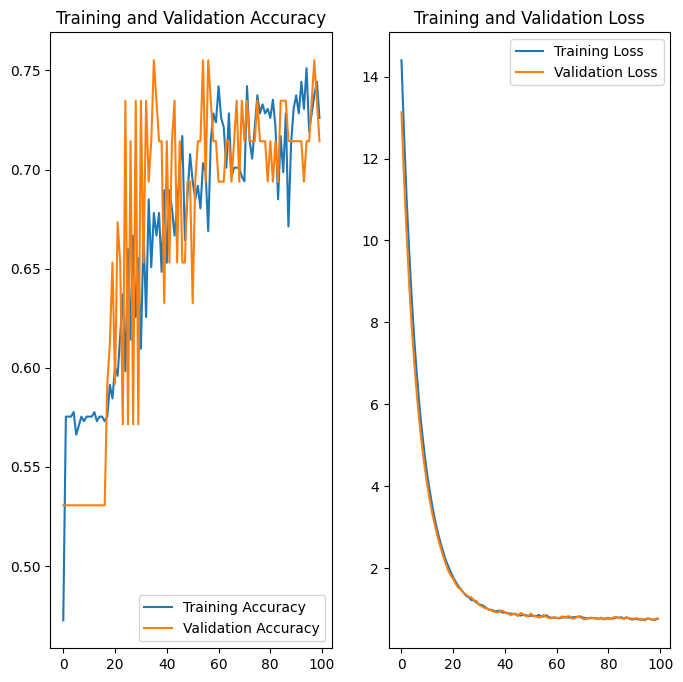

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(min(epochs, len(acc)))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
#load the best model using the callback
model.load_weights(checkpoint_filepath)

print("\n\nEvaluating Best Model\n")
#evaluation the model on the validation data
model.evaluate(valData, valLabels, verbose=2)


#Best val acc so far: 0.796



Evaluating Best Model

2/2 - 0s - loss: 0.9598 - accuracy: 0.7551 - 103ms/epoch - 52ms/step


[0.9598457217216492, 0.7551020383834839]

In [ ]:
#save the model
model.save("/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 2/bestModel.keras")
print("Saved Model")

# Testing Script

In [26]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt

## Mount Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 2/'


###############################################################################
#Reading data and normalization

#read test.csv, dropping the first column as it just holds the index of the rows, which we don't need
testData = pd.read_csv(data_dir + "test.csv", sep=',', usecols=[1, 2, 3, 4], names = ['Heart Rate', 'Respiratory Rate', 'O2 Level', 'Label'])


# #Normalize the test data using the normalization factors we found in the training data. Hard coded here
normValues = [[40, 200], [15, 90], [80, 100]]   #from training
testData['Heart Rate'] = (testData['Heart Rate'] - normValues[0][0]) / (normValues[0][1] - normValues[0][0])
testData['Respiratory Rate'] = (testData['Respiratory Rate'] - normValues[1][0]) / (normValues[1][1] - normValues[1][0])
testData['O2 Level'] = (testData['O2 Level'] - normValues[2][0]) / (normValues[2][1] - normValues[2][0])


###############################################################################
#Seperating normalized data into sequences

#now we need to process the data by seperating the entire data array into 31 row chunks
testData = np.array_split(testData, np.arange(31, len(testData), 31))

#pull the labels from the first row of each sequence, save it to an array, then drop the label col from this data sequence
testLabels = []
for seq in testData:
  label = seq['Label'].iloc[0]    #get the first rows label, and use it for this whole sequence
  seq.drop('Label', axis=1, inplace=True)
  testLabels.append(label)

testLabels = np.asarray(testLabels).astype('int32')

#convert dataframes into np arrays and make the whole dataset multidimensional instead of an array of dataframes for tensorflow to properly use
testData = np.array([np.array(seq) for seq in testData])



###############################################################################
#Testing model

#load the model from a saved file
model = tf.keras.models.load_model(data_dir + "bestModel.keras")

#evaluation the model on the test data
loss, acc = model.evaluate(testData, testLabels, verbose=2)
print("Loss on test data: ", loss)
print("Accuracy on test data: ", acc)

Mounted at /content/drive
1/1 - 12s - loss: 1.0334 - accuracy: 0.5000 - 12s/epoch - 12s/step
Loss on test data:  1.033374547958374
Accuracy on test data:  0.5
